# EDA in SQL
* Datasets from https://www.datacamp.com/tracks/sql-for-business-analysts


## Importing Libraries

In [34]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Connect to PostgreSQL

In [35]:
def create_db_connection(host_name, user_name, user_password, db_name):
    conn = None
    try:
        conn = pg.connect(
            host=host_name,
            user = user_name,
            password = user_password,
            database = db_name
        )
        print("PostgreSQL '{}' Database connection successful".format(db_name))
    except Exception as e:
        print(f"Error: '{e}'")
    return conn

In [36]:
conn = create_db_connection('localhost', 'postgres', 'password', 'sqlda1')
cur = conn.cursor()

PostgreSQL 'sqlda1' Database connection successful


# Explore the database
![](images/entity-relationship-diagram.png)

* `evanston311` contains help requests sent to the city of Evanston, Illinois
* `fortune500` contains information on the 500 largest US companies by revenue from 2017
* `stackoverflow` contains data from popular programming question and answer site
* `company`, `tag_company`, and `tag_type` are supporting tables with additional information related to `stackoverflow` data

### Get list of tables and column types

`information_schema` is a meta-database that holds information about your current database. 
* `tables`: information about all tables in current db
* `columns`: information about all columns of the tables in current db

In [37]:
q = """
select table_schema, table_name 
from information_schema.tables
where table_schema = 'public';
"""

pd.read_sql(q, conn)

,table_schema,table_name
0,public,evanston311
1,public,company
2,public,tag_company
3,public,stackoverflow
4,public,tag_type
5,public,fortune500


In [38]:
q = """
select table_name, column_name, data_type
from information_schema.columns
where table_schema='public'
order by table_name
"""

df = pd.read_sql(q, conn)
df

,table_name,column_name,data_type
0,company,id,integer
1,company,parent_id,integer
2,company,name,character varying
3,company,ticker,character
4,company,exchange,character varying
5,evanston311,id,integer
6,evanston311,description,text
7,evanston311,priority,character varying
8,evanston311,source,character varying
9,evanston311,zip,character


### Count missing values
* Which column of `fortune500` has the most missing values? To find out, need to check each column individually
* Thats where SQL in Python becomes useful

In [39]:
# Manually count missing values in each column
q = """
select count(*) - count(industry) as industry_missing
from fortune500;
"""

pd.read_sql(q, conn)


,industry_missing
0,13


In [40]:
q = """
select * from fortune500;
"""

# Use python to count missing values
pd.read_sql(q,conn).isna().sum()

rank                0
title               0
name                0
ticker             32
url                 0
hq                  0
sector              0
industry           13
employees           0
revenues            5
revenues_change     0
profits             1
profits_change     63
assets              0
equity              0
dtype: int64

### Join tables
* Refer to entity relationship diagram

In [41]:
q = """
select company.name, fortune500.ticker, sector, profits
from company
inner join fortune500
on company.ticker = fortune500.ticker;
"""

pd.read_sql(q,conn)

,name,ticker,sector,profits
0,Apple Incorporated,AAPL,Technology,45687.0
1,Amazon.com Inc,AMZN,Technology,2371.0
2,Alphabet,GOOGL,Technology,19478.0
3,Microsoft Corp.,MSFT,Technology,16798.0
4,International Business Machines Corporation,IBM,Technology,11872.0
5,PayPal Holdings Incorporated,PYPL,Business Services,1401.0
6,"eBay, Inc.",EBAY,Technology,7266.0
7,Adobe Systems Incorporated,ADBE,Technology,1168.8


# What is the most common `stackoverflow` `tag_type`?

In [42]:
q = """
select type, count(type) as tag_type_count
from tag_type
group by type
order by tag_type_count desc
;
"""
pd.read_sql(q,conn)

,type,tag_type_count
0,cloud,31
1,database,6
2,payment,5
3,mobile-os,4
4,api,4
5,company,4
6,storage,2
7,os,2
8,spreadsheet,2
9,identity,1


# What companies have a `tag` of the most common `type`?

In [43]:
q = """
with cte as (
    select type, count(type) as tag_type_count
    from tag_type
    group by type
), most_common_type as (
select type
from cte
where tag_type_count = (select max(tag_type_count) from cte)
)


select name, tag_type.tag, tag_type.type
from company
inner join tag_company
on company.id = tag_company.company_id
inner join tag_type
on tag_company.tag = tag_type.tag
where type = (select type from most_common_type)
;
"""

pd.read_sql(q,conn)

,name,tag,type
0,Amazon Web Services,amazon-cloudformation,cloud
1,Amazon Web Services,amazon-cloudfront,cloud
2,Amazon Web Services,amazon-cloudsearch,cloud
3,Amazon Web Services,amazon-cloudwatch,cloud
4,Amazon Web Services,amazon-cognito,cloud
5,Amazon Web Services,amazon-data-pipeline,cloud
6,Amazon Web Services,amazon-dynamodb,cloud
7,Amazon Web Services,amazon-ebs,cloud
8,Amazon Web Services,amazon-ec2,cloud
9,Amazon Web Services,amazon-ecs,cloud


# What is the most common industry in `fortune500`?
* The `industry` contains missing values so use `sector` if industry is missing
* Use `coalesce()` on `industry` and `sector`

In [44]:
q = """
select name, sector, industry
 from fortune500;
"""

pd.read_sql(q,conn).isna().sum()


name         0
sector       0
industry    13
dtype: int64

In [45]:
# coalesce selects the first not-null value in the options
q = """
select coalesce(industry, sector, 'Unknown') as industry_or_sector, count(*)
from fortune500
group by industry_or_sector
order by count desc
limit 10
"""

pd.read_sql(q, conn)

,industry_or_sector,count
0,Utilities: Gas and Electric,22
1,Specialty Retailers: Other,21
2,Commercial Banks,19
3,Insurance: Property and Casualty (Stock),19
4,Chemicals,14
5,Food Consumer Products,13
6,Diversified Financials,12
7,Aerospace and Defense,12
8,"Insurance: Life, Health (Stock)",10
9,Energy,10


# Rank companies that are subsidiaries of Fortune 500 companies as well

In [46]:
q = """
select original.name, title, rank
from company as original
left join company as parent
on original.parent_id = parent.id
inner join fortune500
on coalesce(parent.ticker, original.ticker) = fortune500.ticker
order by rank
"""

pd.read_sql(q,conn)

,name,title,rank
0,Apple Incorporated,Apple,3
1,Amazon.com Inc,Amazon.com,12
2,Amazon Web Services,Amazon.com,12
3,Alphabet,Alphabet,27
4,Google LLC,Alphabet,27
5,Microsoft Corp.,Microsoft,28
6,International Business Machines Corporation,IBM,32
7,PayPal Holdings Incorporated,PayPal Holdings,264
8,"eBay, Inc.",eBay,310
9,Adobe Systems Incorporated,Adobe Systems,443


# Summarise the distribution of revenue for Fortune 500 companies

Text(0.5, 1.0, 'Distribution of Fortune 500 Companies Revenue Change')

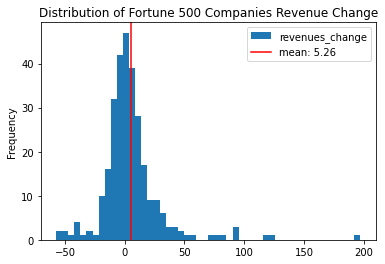

In [47]:
q = """
select revenues_change, count(*)
from fortune500
group by revenues_change
order by revenues_change;
"""

df = pd.read_sql(q,conn)
df.revenues_change.plot(kind='hist', bins=50)

mu = df.revenues_change.mean()
plt.axvline(mu, color='r', label='mean: {:.2f}'.format(mu))
plt.legend()
plt.title('Distribution of Fortune 500 Companies Revenue Change')

# How many of the Fortune 500 companies had revenues increase?

In [48]:
q = """
select count(*) as revenue_increase_count
from fortune500
where revenues_change > 0
"""

pd.read_sql(q,conn)

,revenue_increase_count
0,298


In [49]:
q = """
with total_increase as (
    select count(*) as total_increase
    from fortune500
    where revenues_change > 0
),
total_companies as (
    select count(*) as total_companies
    from fortune500
)

select total_increase, total_companies, (total_increase*100/total_companies)as pct
from total_increase, total_companies

"""
pd.read_sql(q,conn)

,total_increase,total_companies,pct
0,298,500,59


# What is the average revenue per employee for Fortune 500 companies by sector?

In [50]:
q = """
select sector, round(avg(revenues/employees::numeric),2) as avg_revenue_employee
from fortune500
group by sector
order by avg_revenue_employee desc;
"""
pd.read_sql(q,conn)

,sector,avg_revenue_employee
0,Materials,4.76
1,Energy,1.83
2,Financials,1.73
3,Wholesalers,1.41
4,Engineering & Construction,0.86
5,"Food, Beverages & Tobacco",0.83
6,Media,0.80
7,Health Care,0.79
8,Telecommunications,0.63
9,Chemicals,0.60


# Summarise the profits for Fortune 500 Companies

In [51]:
pd.read_sql('select profits from fortune500', conn).describe()

,profits
count,499.000000
mean,1783.475351
std,3940.495363
min,-6177.000000
25%,238.600000
50%,687.200000
75%,1773.550000
max,45687.000000


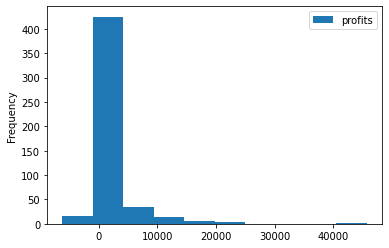

In [52]:
pd.read_sql('select profits from fortune500', conn).plot(kind='hist');


In [53]:
q = """
select sector, min(profits), max(profits), avg(profits), stddev(profits)
from fortune500
group by sector
order by avg desc
"""

pd.read_sql(q,conn)

,sector,min,max,avg,stddev
0,Technology,-1672.0,45687.0,4137.241860,8042.983364
1,Telecommunications,-383.5,13127.0,4127.280000,5400.731733
2,Health Care,-1721.0,16540.0,2773.260526,3751.818796
3,Financials,-1128.0,24733.0,2719.776190,5064.764071
4,"Food, Beverages & Tobacco",-677.0,14239.0,2346.183333,3412.352156
5,Aerospace & Defense,-941.0,5302.0,2093.308333,2064.779952
6,Motor Vehicles & Parts,-674.9,9427.0,1919.533333,3176.300732
7,Media,-495.9,9391.0,1821.336364,2839.299478
8,Industrials,-176.1,8831.0,1727.689474,2326.018251
9,Transportation,69.0,4373.0,1670.294118,1373.013161


In [54]:
df = pd.read_sql('select sector, profits from fortune500', conn)

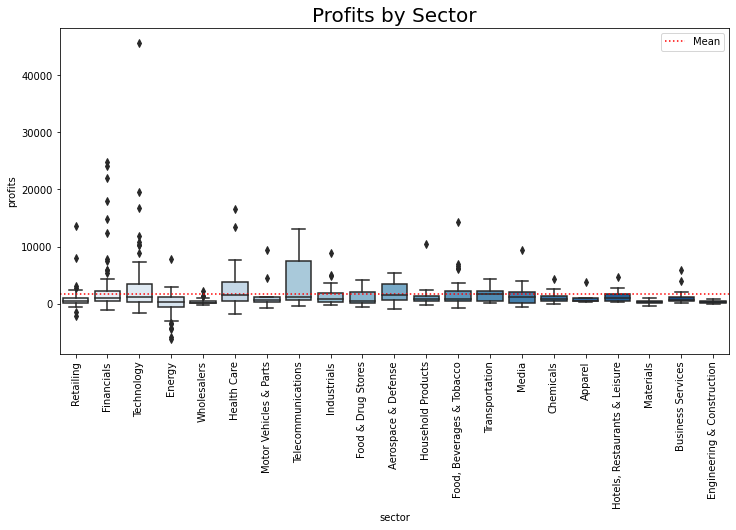

In [55]:
plt.figure(figsize=(12,6))

plt.title('Profits by Sector', fontsize=20)
sns.boxplot(data=df, x='sector', y='profits', palette='Blues')
plt.axhline(df.profits.mean(), color='r', ls=':', label='Mean')
plt.legend()
plt.xticks(rotation=90);

# What's the relationship between a company's revenue and its other financial attributes?

In [56]:
q = """
select 
corr(revenues, profits) as rev_profits,
corr(revenues, assets) as rev_assets,
corr(revenues, equity) as rev_equity
from fortune500;
"""

pd.read_sql(q,conn)

,rev_profits,rev_assets,rev_equity
0,0.599994,0.3295,0.546571


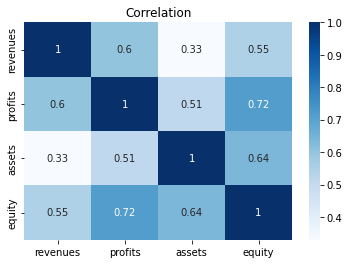

In [57]:
df = pd.read_sql('select revenues, profits, assets, equity from fortune500',conn)
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.title('Correlation');


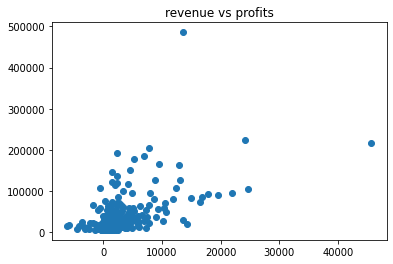

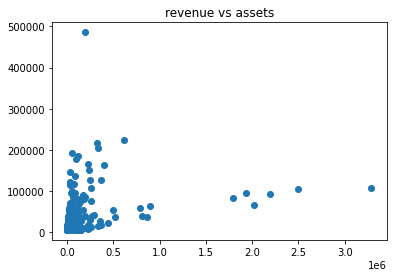

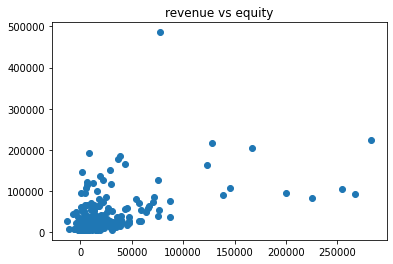

In [58]:

for i in ['profits', 'assets', 'equity']:
    plt.scatter(x=df[i], y=df.revenues)
    plt.title('revenue vs ' + str(i))
    plt.show();

# Find the Fortune 500 companies that have profits in the top 20% for their sector (compared to other Fortune 500 companies).

In [59]:
q = """
with cte as (
    select sector,
    percentile_disc(.8) within group (order by profits) as pct80
    from fortune500
    group by sector
)

select title, fortune500.sector, profits, profits/pct80 as ratio
from fortune500
left join cte
on fortune500.sector = cte.sector
where profits > pct80
"""

pd.read_sql(q,conn)

,title,sector,profits,ratio
0,Walmart,Retailing,13643.0,11.109935
1,Berkshire Hathaway,Financials,24074.0,7.987392
2,Apple,Technology,45687.0,6.287779
3,Exxon Mobil,Energy,7840.0,5.980168
4,McKesson,Wholesalers,2258.0,3.726688
...,...,...,...,...
85,AutoZone,Retailing,1241.0,1.010586
86,Sempra Energy,Energy,1370.0,1.045004
87,Weyerhaeuser,Materials,1027.0,2.070565
88,PPL,Energy,1902.0,1.450801


# Some of the `street` values in `evanston311` include house numbers. Remove them to clean up the values

In [60]:
# View the values
q = """
select distinct(street)
from evanston311
order by street;
"""

pd.read_sql(q, conn)

,street
0,1/2 Chicago Ave
1,1047B Chicago Ave
2,13th Street
3,141A Callan Ave
4,141b Callan Ave
...,...
700,Wilmette Avenue
701,Woodbine Ave
702,Woodbine Avenue
703,Woodland Road


In [61]:
# Trim the numbers

q = """
select distinct street,
trim(street, '0123456789 #/.') as cleaned_street
from evanston311
order by street;
"""

pd.read_sql(q,conn)

,street,cleaned_street
0,1/2 Chicago Ave,Chicago Ave
1,1047B Chicago Ave,B Chicago Ave
2,13th Street,th Street
3,141A Callan Ave,A Callan Ave
4,141b Callan Ave,b Callan Ave
...,...,...
700,Wilmette Avenue,Wilmette Avenue
701,Woodbine Ave,Woodbine Ave
702,Woodbine Avenue,Woodbine Avenue
703,Woodland Road,Woodland Road


# What are the most frequent description with 'trash' or 'garbage'?

In [62]:
q = """
select count(*)
from evanston311
where description ilike '%trash%'
or description ilike '%garbage%';
"""
pd.read_sql(q,conn)

,count
0,2551


In [63]:
conn.close()